https://www.wisnupriambodo.com/

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/sample_data/catvdog/cats_and_dogs_filtered.zip

--2022-12-07 11:42:05--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/sample_data/catvdog/cats_and_dogs_filtered.zip’

/content/sample_dat 100%[===================>]  65.43M  93.2MB/s    in 0.7s    

2022-12-07 11:42:05 (93.2 MB/s) - ‘/content/sample_data/catvdog/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/content/sample_data/catvdog/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/sample_data/catvdog')
zip_ref.close()

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import time

In [ ]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [ ]:
torch.__version__

'1.12.1+cu113'

In [ ]:
import torchvision
torchvision.__version__

'0.13.1+cu113'

In [ ]:
# 
input_path = "/content/sample_data/catvdog/cats_and_dogs_filtered/"

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Use resnet pre-processing
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
model = models.resnet50(pretrained=True).to(device)
# model = models.densenet121(pretrained=True).to(device)
# print(model)
for param in model.parameters():
    param.requires_grad = False   

# num_ftrs = model.classifier.in_features
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
# model.classifier = nn.Sequential(
#                nn.Linear(num_ftrs, 128),
#                nn.ReLU(inplace=True),
#                nn.Linear(128, 2)).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
# Optimzer
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
# LR scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    cooldown=4,
                                                    verbose=True)

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=3):
    last_end = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            epoch_time = time.time() - last_end
            last_end = time.time()
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            print('Epoch Time {epoch_time:.3f}'.format(epoch_time=epoch_time))
            if phase == 'validation':
                lr_scheduler.step(epoch_loss)
                print('-' * 10)
    return model

In [ ]:
model_trained = train_model(model, criterion, optimizer, num_epochs=20)

In [ ]:
!mkdir models
!mkdir models/pytorch

In [ ]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [ ]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
validation_img_paths = ["validation/cats/cat.2000.jpg",
                        "validation/cats/cat.2001.jpg",
                        "validation/dogs/dog.2001.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [ ]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [ ]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 2.9073, -2.9738],
        [ 1.8299, -2.0002],
        [-4.9259,  3.8206]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.9721611e-01, 2.7838277e-03],
       [9.7875196e-01, 2.1248072e-02],
       [1.5898921e-04, 9.9984097e-01]], dtype=float32)

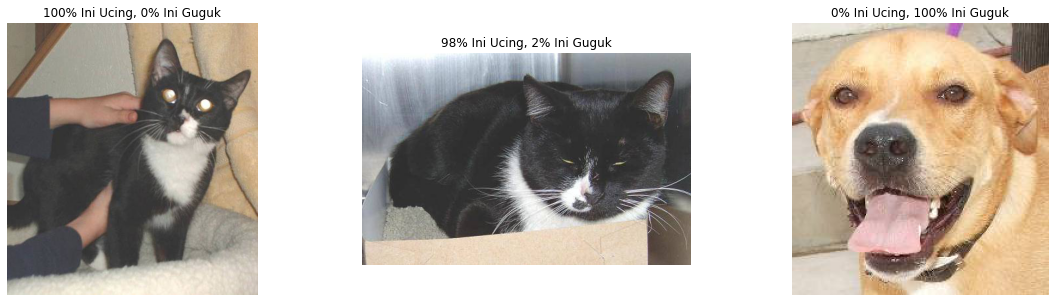

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Ini Ucing, {:.0f}% Ini Guguk".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)